In [6]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
import os
import tarfile
import shutil
import subprocess
import logging
from datetime import datetime
from pathlib import Path

In [23]:
def to_decimal(val):
    if isinstance(val, (int, float)):
        return Decimal(str(val))  # str() важен для точности
    return val

reference_affinity = pd.read_csv("C:\\Users\\Professional\\Documents\\docking_11.05.2025\\affinity.csv")
reference_affinity = reference_affinity.rename(columns={"Unnamed: 0": "Variant"})
reference_affinity = reference_affinity.replace("e-12", np.float64(1e-13)).applymap(to_decimal)
reference_affinity = reference_affinity.set_index('Variant')
reference_affinity

C:\Users\Professional\AppData\Local\Temp\ipykernel_27640\405209181.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  reference_affinity = reference_affinity.replace("e-12", np.float64(1e-13)).applymap(to_decimal)


,VHH7,VHH57,VHH58
Variant,,,
EG.5,3.06E-10,NaN,1.70e-10
HV.1,2.38E-10,4.53E-9,1.51e-10
JN.1,2.49E-10,3.62E-9,1E-13
KP.2,6.47E-10,NaN,4.86e-11
KP.3.1.1,4.23E-10,NaN,4.23e-10
WU,1.37E-10,5.19E-10,9.31e-11
BA.1,1.57E-10,2.8E-10,1E-13
BA.4/5,4.07E-10,1.93E-9,1E-13
XBB.1.5,2.39E-9,1.15E-9,6.31e-11


In [133]:
# Настройка логирования
logging.basicConfig(
    filename='process.log',  # Логирование в файл
    level=logging.INFO,  # Уровень логирования
    format='%(asctime)s - %(levelname)s - %(message)s'
)

base_dir = Path("/home/mr-red/Рабочий стол/epitope_mapping/docking_11.05.2025/results/2025_05_11")
script_path = Path("/home/mr-red/Рабочий стол/epitope_mapping/docking_11.05.2025/reference_pdbs/vhhs_rbds/run_all_prodigy.sh")

# Словарь для хранения результатов
results_dict = {}

# Обход папок
for repo_dir in base_dir.iterdir():
    if not repo_dir.is_dir():
        continue

    repo_name = repo_dir.name
    analysis_path = repo_dir / "analysis" / "11_caprieval_analysis"
    archive_path = analysis_path / "summary.tgz"
    extracted_path = analysis_path / "summary"
    
    # Логирование разделения между итерациями
    logging.info("="*50)
    print("="*50)
    logging.info(f"Начинается обработка репозитория {repo_name} в {datetime.now()}")
    print(f"Начинается обработка репозитория {repo_name} в {datetime.now()}")
    
    # Проверка существования архива
    if archive_path.exists():
        logging.info(f"Файл summary.tgz найден в {archive_path}")
        print(f"Файл summary.tgz найден в {archive_path}")

        # Проверка, существует ли уже распакованная папка summary
        if extracted_path.exists() and extracted_path.is_dir():
            logging.info(f"Папка {extracted_path} уже существует, распаковка не требуется.")
            print(f"Папка {extracted_path} уже существует, распаковка не требуется.")
        else:
            # Распаковка архива, если папка summary не существует
            logging.info(f"Распаковка архива {archive_path} в {extracted_path}.")
            print(f"Распаковка архива {archive_path} в {extracted_path}.")
            
            # Распаковка архива
            with tarfile.open(archive_path, "r:gz") as tar:
                tar.extractall(path=extracted_path)
            logging.info(f"Архив {archive_path} успешно распакован.")
            print(f"Архив {archive_path} успешно распакован.")

        # Копирование скрипта в папку summary
        if extracted_path.exists() and extracted_path.is_dir():
            destination_script_path = extracted_path / script_path.name  # Путь, куда будет скопирован скрипт
            shutil.copy(script_path, destination_script_path)  # Копируем скрипт
            logging.info(f"Скрипт {script_path} скопирован в {destination_script_path}")
            print(f"Скрипт {script_path} скопирован в {destination_script_path}")

            # Запуск скрипта
            logging.info(f"Запуск скрипта {destination_script_path} в папке {extracted_path}.")
            print(f"Запуск скрипта {destination_script_path} в папке {extracted_path}.")
            subprocess.run(["bash", destination_script_path], cwd=extracted_path, check=True)

            # Проверка, появился ли файл prodigy_summary.csv
            prodigy_summary_path = extracted_path / "prodigy_summary.csv"
            if prodigy_summary_path.exists():
                logging.info(f"Файл prodigy_summary.csv найден в {prodigy_summary_path}.")
                print(f"Файл prodigy_summary.csv найден в {prodigy_summary_path}.")

                # Чтение данных из CSV в DataFrame
                df = pd.read_csv(prodigy_summary_path)

                # Добавление данных в словарь
                results_dict[repo_name] = df
                logging.info(f"Данные для {repo_name} успешно добавлены в словарь.")
            else:
                logging.warning(f"Файл prodigy_summary.csv не найден в {extracted_path}.")
                print(f"Файл prodigy_summary.csv не найден в {extracted_path}.")
    else:
        logging.warning(f"Файл summary.tgz не найден в {archive_path}")
        print(f"Файл summary.tgz не найден в {archive_path}")

    # Логирование завершения итерации
    logging.info("="*50)
    print("="*50)

# Результаты в словаре
logging.info("Проверка завершена. Данные для всех репозиториев собраны.")
print("Проверка завершена. Подробности в логах.")

Начинается обработка репозитория BA.1_8bgg_C-vhh57-2025_05_11 в 2025-05-13 08:06:33.029466
Файл summary.tgz найден в /home/mr-red/Рабочий стол/epitope_mapping/docking_11.05.2025/results/2025_05_11/BA.1_8bgg_C-vhh57-2025_05_11/analysis/11_caprieval_analysis/summary.tgz
Папка /home/mr-red/Рабочий стол/epitope_mapping/docking_11.05.2025/results/2025_05_11/BA.1_8bgg_C-vhh57-2025_05_11/analysis/11_caprieval_analysis/summary уже существует, распаковка не требуется.
Скрипт /home/mr-red/Рабочий стол/epitope_mapping/docking_11.05.2025/reference_pdbs/vhhs_rbds/run_all_prodigy.sh скопирован в /home/mr-red/Рабочий стол/epitope_mapping/docking_11.05.2025/results/2025_05_11/BA.1_8bgg_C-vhh57-2025_05_11/analysis/11_caprieval_analysis/summary/run_all_prodigy.sh
Запуск скрипта /home/mr-red/Рабочий стол/epitope_mapping/docking_11.05.2025/results/2025_05_11/BA.1_8bgg_C-vhh57-2025_05_11/analysis/11_caprieval_analysis/summary/run_all_prodigy.sh в папке /home/mr-red/Рабочий стол/epitope_mapping/docking_11.0

In [134]:
import re

def merge_results_to_dataframe(results_dict):
    merged_data = []

    for repo_name, df in results_dict.items():
        # Разбор имени репозитория
        try:
            variant_pdb_chain, antibody, date = repo_name.rsplit("-", 2)
            variant, pdb_id, chain = variant_pdb_chain.split("_")
        except ValueError:
            print(f"Не удалось разобрать имя репозитория: {repo_name}")
            continue

        # Добавление колонок с разобранной информацией
        df['repo_name'] = repo_name
        df['variant'] = variant
        df['pdb_id'] = pdb_id
        df['chain'] = chain
        df['antibody'] = antibody
        df['date'] = date

        # Переименование колонки с Kd
        if 'DissociationConstant(M)' in df.columns:
            df = df.rename(columns={'DissociationConstant(M)': 'Kd'})

        # Разбор информации из названия файла
        if 'Filename' in df.columns:
            # Извлекаем cluster и model с помощью регулярного выражения
            def extract_cluster_model(filename):
                match = re.search(r'cluster_(\d+)_model_(\d+)\.pdb', filename)
                if match:
                    return int(match.group(1)), int(match.group(2))
                return None, None

            df[['cluster', 'model']] = df['Filename'].apply(
                lambda x: pd.Series(extract_cluster_model(x))
            )

        merged_data.append(df)

    # Объединение всех в один DataFrame
    final_df = pd.concat(merged_data, ignore_index=True)

    return final_df

# Пример использования:
results_df = merge_results_to_dataframe(results_dict)
results_df["Kd"] = results_df["Kd"].apply(lambda x: Decimal(str(x)) if pd.notna(x) else None)
results_df.to_csv("/home/mr-red/Рабочий стол/epitope_mapping/docking_11.05.2025/results/2025_05_11/results_2025_05_11.csv")
results_df

,Filename,Kd,repo_name,variant,pdb_id,chain,antibody,date,cluster,model
0,cluster_10_model_1.pdb,2.4E-8,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,10,1
1,cluster_10_model_2.pdb,1.7E-8,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,10,2
2,cluster_10_model_3.pdb,1.7E-7,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,10,3
3,cluster_10_model_4.pdb,4.1E-8,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,10,4
4,cluster_1_model_1.pdb,1.7E-9,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,1,1
...,...,...,...,...,...,...,...,...,...,...
1879,cluster_8_model_4.pdb,4.9E-8,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,vhh57,2025_05_11,8,4
1880,cluster_9_model_1.pdb,2.6E-9,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,vhh57,2025_05_11,9,1
1881,cluster_9_model_2.pdb,1.1E-8,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,vhh57,2025_05_11,9,2
1882,cluster_9_model_3.pdb,8.1E-9,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,vhh57,2025_05_11,9,3


In [16]:
results_df = pd.read_csv("C:\\Users\\Professional\\Documents\\docking_11.05.2025\\results\\2025_05_11\\results_2025_05_11.csv")
results_df = results_df.drop(columns=["Unnamed: 0"]).replace("EG.5.1", "EG.5")
results_df["Kd"] = results_df["Kd"].apply(lambda x: Decimal(str(x)) if pd.notna(x) else None)
results_df

,Filename,Kd,repo_name,variant,pdb_id,chain,antibody,date,cluster,model
0,cluster_10_model_1.pdb,2.4E-8,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,10,1
1,cluster_10_model_2.pdb,1.7E-8,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,10,2
2,cluster_10_model_3.pdb,1.7E-7,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,10,3
3,cluster_10_model_4.pdb,4.1E-8,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,10,4
4,cluster_1_model_1.pdb,1.7E-9,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,1,1
...,...,...,...,...,...,...,...,...,...,...
1879,cluster_8_model_4.pdb,4.9E-8,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,vhh57,2025_05_11,8,4
1880,cluster_9_model_1.pdb,2.6E-9,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,vhh57,2025_05_11,9,1
1881,cluster_9_model_2.pdb,1.1E-8,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,vhh57,2025_05_11,9,2
1882,cluster_9_model_3.pdb,8.1E-9,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,vhh57,2025_05_11,9,3


In [32]:
set(results_df.variant)

{'BA.1',
 'BA.2',
 'BA.2.86',
 'BQ.1.1',
 'EG.5',
 'HV.1',
 'JN.1',
 'WU',
 'XBB',
 'XBB.1',
 'XBB.1.5'}

In [27]:
reference_affinity = reference_affinity.rename(columns=lambda x: x.lower())
reference_affinity.index.name = None
reference_affinity = reference_affinity.reset_index().rename(columns={'index': 'variant'})

reference_affinity

,variant,vhh7,vhh57,vhh58
0,EG.5,3.06E-10,NaN,1.70e-10
1,HV.1,2.38E-10,4.53E-9,1.51e-10
2,JN.1,2.49E-10,3.62E-9,1E-13
3,KP.2,6.47E-10,NaN,4.86e-11
4,KP.3.1.1,4.23E-10,NaN,4.23e-10
5,WU,1.37E-10,5.19E-10,9.31e-11
6,BA.1,1.57E-10,2.8E-10,1E-13
7,BA.4/5,4.07E-10,1.93E-9,1E-13
8,XBB.1.5,2.39E-9,1.15E-9,6.31e-11


In [34]:
# Шаг 1: Преобразуем reference_affinity в длинный формат
reference_affinity_long = reference_affinity.reset_index().melt(
    id_vars=["variant"],
    var_name="antibody",
    value_name="Kd_reference"
)

# Преобразуем значения в Decimal
reference_affinity_long["Kd_reference"] = reference_affinity_long["Kd_reference"].apply(
    lambda x: Decimal(str(x)) if pd.notna(x) else None
)

# Шаг 2: Объединяем по variant и antibody (внутреннее объединение)
merged_df = pd.merge(
    results_df,
    reference_affinity_long,
    on=["variant", "antibody"],
    how="inner"  # только те строки, где есть совпадения
)

# Готово
merged_df

,Filename,Kd,repo_name,variant,pdb_id,chain,antibody,date,cluster,model,Kd_reference
0,cluster_10_model_1.pdb,2.4E-8,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,10,1,2.8E-10
1,cluster_10_model_2.pdb,1.7E-8,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,10,2,2.8E-10
2,cluster_10_model_3.pdb,1.7E-7,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,10,3,2.8E-10
3,cluster_10_model_4.pdb,4.1E-8,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,10,4,2.8E-10
4,cluster_1_model_1.pdb,1.7E-9,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,vhh57,2025_05_11,1,1,2.8E-10
...,...,...,...,...,...,...,...,...,...,...,...
1203,cluster_8_model_4.pdb,4.9E-8,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,vhh57,2025_05_11,8,4,5.19E-10
1204,cluster_9_model_1.pdb,2.6E-9,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,vhh57,2025_05_11,9,1,5.19E-10
1205,cluster_9_model_2.pdb,1.1E-8,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,vhh57,2025_05_11,9,2,5.19E-10
1206,cluster_9_model_3.pdb,8.1E-9,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,vhh57,2025_05_11,9,3,5.19E-10


In [ ]:
set(merged_df.repo_name)

{'BA.1_8bgg_C-vhh57-2025_05_11',
 'BA.1_8bgg_C-vhh58-2025_05_11',
 'BA.1_8bgg_C-vhh7-2025_05_11',
 'EG.5.1_8xln_A-vhh57-2025_05_11',
 'EG.5.1_8xln_A-vhh58-2025_05_11',
 'EG.5.1_8xln_A-vhh7-2025_05_11',
 'EG.5.1_8xn2_B-vhh57-2025_05_11',
 'EG.5.1_8xn2_B-vhh58-2025_05_11',
 'EG.5.1_8xn2_B-vhh7-2025_05_11',
 'HV.1_8xn3_B-vhh57-2025_05_11',
 'HV.1_8xn3_B-vhh58-2025_05_11',
 'HV.1_8xn3_B-vhh7-2025_05_11',
 'JN.1_8y18_B-vhh57-2025_05_11',
 'JN.1_8y18_B-vhh58-2025_05_11',
 'JN.1_8y18_B-vhh7-2025_05_11',
 'JN.1_8zbq_F-vhh57-2025_05_11',
 'JN.1_8zbq_F-vhh58-2025_05_11',
 'JN.1_8zbq_F-vhh7-2025_05_11',
 'WU_6lzg_B-vhh57-2025_05_11',
 'WU_6lzg_B-vhh58-2025_05_11',
 'WU_6lzg_B-vhh7-2025_05_11',
 'WU_6vw1_E-vhh57-2025_05_11',
 'WU_6vw1_E-vhh58-2025_05_11',
 'WU_6vw1_E-vhh7-2025_05_11',
 'WU_6w41_C-vhh57-2025_05_11',
 'WU_6w41_C-vhh58-2025_05_11',
 'WU_6w41_C-vhh7-2025_05_11',
 'WU_7l7e_K-vhh57-2025_05_11',
 'WU_7l7e_K-vhh58-2025_05_11',
 'WU_7l7e_K-vhh7-2025_05_11',
 'XBB.1.5_8wrl_B-vhh57-2025_05_1

In [36]:
# Вычисляем fold change (в Decimal, потом преобразуем в float для логарифма)
merged_df["fold_change"] = merged_df.apply(
    lambda row: row["Kd"] / row["Kd_reference"] if row["Kd_reference"] else None,
    axis=1
)

# Логарифм по основанию 10
merged_df["log10_fold_change"] = merged_df["fold_change"].apply(
    lambda x: np.log10(float(x)) if x is not None else None
)

# Округляем fold_change до 3 знаков после запятой
merged_df["fold_change"] = merged_df["fold_change"].apply(lambda x: round(x, 3) if x is not None else None)

# Округляем Kd и Kd_reference до научной записи с 2 значащими цифрами
merged_df["Kd"] = merged_df["Kd"].apply(lambda x: f"{x:.2E}" if x is not None else None)
merged_df["Kd_reference"] = merged_df["Kd_reference"].apply(lambda x: f"{x:.2E}" if x is not None else None)

# Проверка
merged_df[["variant", "antibody", "Kd", "Kd_reference", "fold_change", "log10_fold_change"]]

,variant,antibody,Kd,Kd_reference,fold_change,log10_fold_change
0,BA.1,vhh57,2.40E-8,2.80E-10,85.714,1.933053
1,BA.1,vhh57,1.70E-8,2.80E-10,60.714,1.783291
2,BA.1,vhh57,1.70E-7,2.80E-10,607.143,2.783291
3,BA.1,vhh57,4.10E-8,2.80E-10,146.429,2.165626
4,BA.1,vhh57,1.70E-9,2.80E-10,6.071,0.783291
...,...,...,...,...,...,...
1203,WU,vhh57,4.90E-8,5.19E-10,94.412,1.975029
1204,WU,vhh57,2.60E-9,5.19E-10,5.010,0.699806
1205,WU,vhh57,1.10E-8,5.19E-10,21.195,1.326225
1206,WU,vhh57,8.10E-9,5.19E-10,15.607,1.193318


In [37]:
set(merged_df.variant)

{'BA.1', 'EG.5', 'HV.1', 'JN.1', 'WU', 'XBB.1.5'}

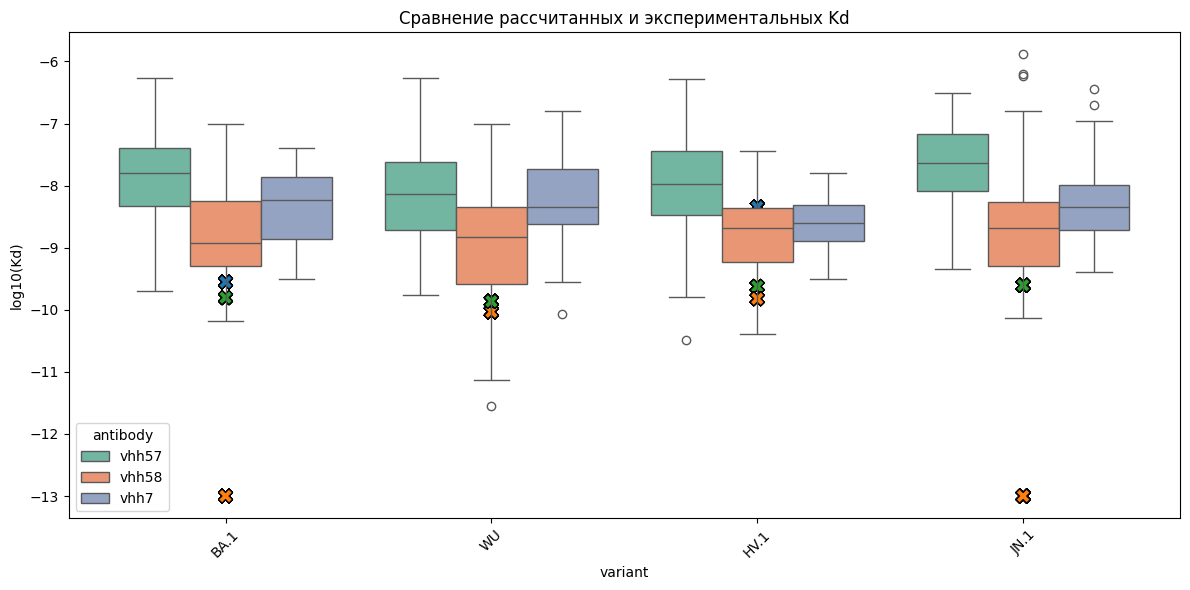

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Добавим логарифмы Kd
merged_df["log10_Kd"] = merged_df["Kd"].apply(lambda x: np.log10(float(x)))
merged_df["log10_Kd_reference"] = merged_df["Kd_reference"].apply(lambda x: np.log10(float(x)))

# Строим
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x="variant", y="log10_Kd", hue="antibody", palette="Set2")
sns.scatterplot(data=merged_df, x="variant", y="log10_Kd_reference", hue="antibody",
                marker="X", s=100, edgecolor="black", legend=False)

plt.xticks(rotation=45)
plt.ylabel("log10(Kd)")
plt.title("Сравнение рассчитанных и экспериментальных Kd")
plt.tight_layout()
plt.show()

In [62]:
from IPython.display import display, Markdown

explanation = r"""
## Отклонение аффинности (Fold-change)

Чтобы оценить, насколько предсказанная модель аффинности (`Kd`) отличается от экспериментального значения, рассчитывается **отклонение (fold-change)** по следующей формуле:

$$
\text{Fold-change} = \frac{K_d^{\text{предсказанное}}}{K_d^{\text{экспериментальное}}}
$$

В логарифмической шкале:

$$
\log_{10}(\text{Fold-change}) = \log_{10}\left( \frac{K_d^{\text{предсказанное}}}{K_d^{\text{экспериментальное}}} \right)
$$

### Что это значит:
- **Fold-change > 1** — модель предсказывает более слабую аффинность, чем в эксперименте.
- **Fold-change < 1** — модель предсказывает более сильное связывание.
- **Fold-change ≈ 1** — хорошее совпадение между моделью и экспериментом.
"""

display(Markdown(explanation))



## Отклонение аффинности (Fold-change)

Чтобы оценить, насколько предсказанная модель аффинности (`Kd`) отличается от экспериментального значения, рассчитывается **отклонение (fold-change)** по следующей формуле:

$$
\text{Fold-change} = \frac{K_d^{\text{предсказанное}}}{K_d^{\text{экспериментальное}}}
$$

В логарифмической шкале:

$$
\log_{10}(\text{Fold-change}) = \log_{10}\left( \frac{K_d^{\text{предсказанное}}}{K_d^{\text{экспериментальное}}} \right)
$$

### Что это значит:
- **Fold-change > 1** — модель предсказывает более слабую аффинность, чем в эксперименте.
- **Fold-change < 1** — модель предсказывает более сильное связывание.
- **Fold-change ≈ 1** — хорошее совпадение между моделью и экспериментом.


C:\Users\Professional\AppData\Local\Temp\ipykernel_27640\2395485134.py:60: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
C:\Users\Professional\AppData\Local\Temp\ipykernel_27640\2395485134.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\Professional\AppData\Local\Temp\ipykernel_27640\2395485134.py:60: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
C:\Users\Professional\AppData\Local\Temp\ipykernel_27640\2395485134.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.s

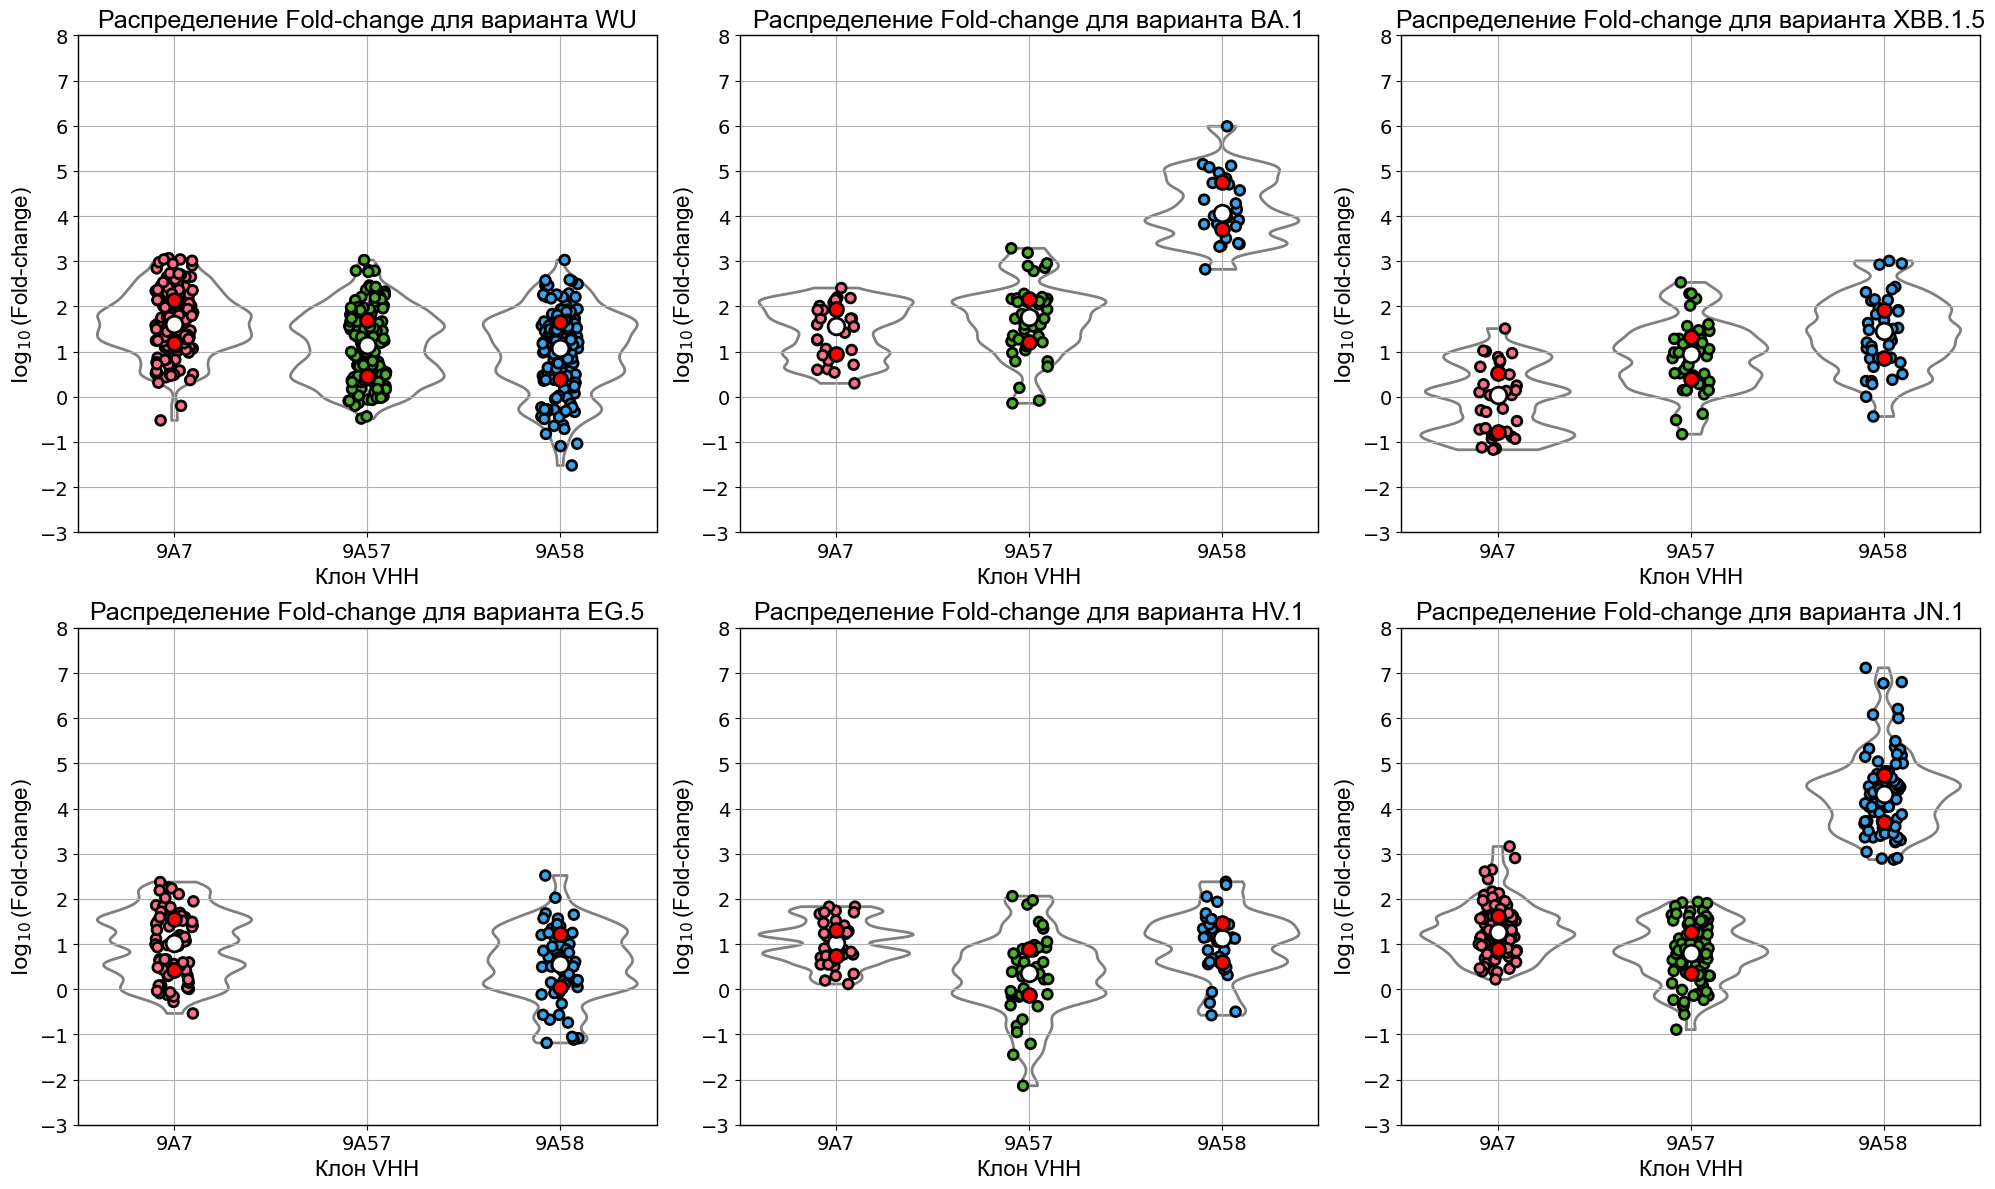

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_statistical_distribution(df, config):
    """
    Функция для построения распределения log10 fold-change с заданным порядком вариантов и VHH:
    Violin plot с дополнением stripplot и swarmplot. Без заливки у виолонов.
    """
    # Извлекаем параметры из конфигурации
    variant_col       = config.get('variant_col', 'variant')
    fold_change_col   = config.get('fold_change_col', 'log10_fold_change')
    antibody_col      = config.get('antibody_col', 'antibody')

    # Жёстко задаём порядок для вариантов вируса и клонов VHH
    variants          = config['variant_order']
    antibody_order    = config['antibody_order']

    # Остальные параметры
    n_cols            = config.get('n_cols', 2)
    color_palette     = config.get('color_palette', sns.color_palette("husl", len(antibody_order)))
    violin_color      = config.get('violin_color', "grey")
    jitter_size       = config.get('jitter_size', 7)
    swarm_edgecolor   = config.get('swarm_edgecolor', 'black')
    swarm_linewidth   = config.get('swarm_linewidth', 2)
    bw_method         = config.get('bw_method', 0.2)
    grid              = config.get('grid', True)
    y_ticks_step      = config.get('y_ticks_step', 1)
    y_min             = config.get('y_min', -3)
    y_max             = config.get('y_max', 8)

    # Шрифты и размеры
    font_family       = config.get('font_family', 'Arial')
    title_font_size   = config.get('title_font_size', 14)
    label_font_size   = config.get('label_font_size', 12)
    tick_font_size    = config.get('tick_font_size', 10)
    median_marker_size= config.get('median_marker_size', 12)

    border_color      = config.get('border_color', 'black')
    border_linewidth  = config.get('border_linewidth', 1)

    fig_width  = config.get('width', 16)
    fig_height = config.get('height', 9)

    # Создаём сетку субплотов
    n_rows = (len(variants) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    axes = axes.flatten()

    for i, variant in enumerate(variants):
        ax = axes[i]
        df_variant = df[df[variant_col] == variant]

        if df_variant.empty:
            ax.set_title(f"Нет данных для {variant}", fontsize=title_font_size, family=font_family)
            ax.axis('off')
            continue

        # Violin plot
        sns.violinplot(
            x=antibody_col,
            y=fold_change_col,
            data=df_variant,
            order=antibody_order,
            cut=0,
            scale='width',
            inner=None,
            linewidth=2,
            bw_method=bw_method,
            color=violin_color,
            fill=False,
            legend=False,
            ax=ax,
            zorder=1
        )

        # Strip plot
        sns.stripplot(
            x=antibody_col,
            y=fold_change_col,
            data=df_variant,
            order=antibody_order,
            size=jitter_size,
            jitter=True,
            linewidth=swarm_linewidth,
            palette=color_palette,
            edgecolor=swarm_edgecolor,
            ax=ax,
            zorder=2
        )

        # Расчёт статистик для swarmplot
        medians = df_variant.groupby(antibody_col)[fold_change_col].median().reset_index()
        q25     = df_variant.groupby(antibody_col)[fold_change_col].quantile(0.25).reset_index()
        q75     = df_variant.groupby(antibody_col)[fold_change_col].quantile(0.75).reset_index()

        # Median markers
        sns.swarmplot(
            x=antibody_col,
            y=fold_change_col,
            data=medians,
            order=antibody_order,
            color='white',
            edgecolor=swarm_edgecolor,
            linewidth=swarm_linewidth,
            size=median_marker_size,
            ax=ax,
            zorder=3
        )
        # Q25 and Q75
        sns.swarmplot(
            x=antibody_col,
            y=fold_change_col,
            data=q25,
            order=antibody_order,
            color='red',
            edgecolor=swarm_edgecolor,
            linewidth=swarm_linewidth,
            size=median_marker_size - 2,
            ax=ax,
            zorder=3
        )
        sns.swarmplot(
            x=antibody_col,
            y=fold_change_col,
            data=q75,
            order=antibody_order,
            color='red',
            edgecolor=swarm_edgecolor,
            linewidth=swarm_linewidth,
            size=median_marker_size - 2,
            ax=ax,
            zorder=3
        )

        # Подписи и оформление
        ax.set_title(f"Распределение Fold-change для варианта {variant}",
                     fontsize=title_font_size, family=font_family)
        ax.set_xlabel("Клон VHH", fontsize=label_font_size, family=font_family)
        ax.set_ylabel(r'$\log_{10}$(Fold-change)', fontsize=label_font_size, family=font_family)

        ax.tick_params(axis='x', labelsize=tick_font_size, rotation=config.get('tick_label_rotation', 0))
        ax.tick_params(axis='y', labelsize=tick_font_size)
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(range(y_min, y_max + 1, y_ticks_step))

        if grid:
            ax.grid(True, zorder=0)

        for spine in ax.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(border_linewidth)

    # Удаление пустых осей
    for j in range(len(variants), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# Пример конфига с жёстким порядком
config = {
    'width': 20,
    'height': 12,
    'variant_col': 'variant',
    'fold_change_col': 'log10_fold_change',
    'antibody_col': 'antibody',
    'n_cols': 3,
    'variant_order': ['WU', 'BA.1', 'XBB.1.5', 'EG.5', 'HV.1', 'JN.1'],
    'antibody_order': ['9A7', '9A57', '9A58'],
    'color_palette': sns.color_palette("husl", 3),
    'violin_color': "grey",
    'jitter_size': 7,
    'swarm_edgecolor': 'black',
    'swarm_linewidth': 2,
    'bw_method': 0.2,
    'grid': True,
    'y_ticks_step': 1,
    'y_min': -3,
    'y_max': 8,
    'font_family': 'Arial',
    'title_font_size': 18,
    'label_font_size': 16,
    'tick_font_size': 14,
    'tick_label_rotation': 0,
    'border_color': 'black',
    'border_linewidth': 1,
    'median_marker_size': 12
}

# Загрузка данных и вызов функции
merged_df = pd.read_csv("C:\\Users\\Professional\\Documents\\docking_11.05.2025\\results\\2025_05_11\\merged_2025_05_11.csv")
# Если нужно переименовать колонки VHH
merged_df[config['antibody_col']] = merged_df[config['antibody_col']].replace({
    "vhh7": "9A7",
    "vhh57": "9A57",
    "vhh58": "9A58"
})

plot_statistical_distribution(merged_df, config)

In [ ]:
merged_df.replace("vhh7", "9A7").replace("vhh57", "9A57").replace("vhh58", "9A58").column_o

,Unnamed: 0,Filename,Kd,repo_name,variant,pdb_id,chain,antibody,date,cluster,model,Kd_reference,fold_change,log10_fold_change
0,0,cluster_10_model_1.pdb,2.400000e-08,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,9A57,2025_05_11,10,1,2.800000e-10,85.714,1.933053
1,1,cluster_10_model_2.pdb,1.700000e-08,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,9A57,2025_05_11,10,2,2.800000e-10,60.714,1.783291
2,2,cluster_10_model_3.pdb,1.700000e-07,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,9A57,2025_05_11,10,3,2.800000e-10,607.143,2.783291
3,3,cluster_10_model_4.pdb,4.100000e-08,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,9A57,2025_05_11,10,4,2.800000e-10,146.429,2.165626
4,4,cluster_1_model_1.pdb,1.700000e-09,BA.1_8bgg_C-vhh57-2025_05_11,BA.1,8bgg,C,9A57,2025_05_11,1,1,2.800000e-10,6.071,0.783291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,999,cluster_8_model_4.pdb,4.900000e-08,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,9A57,2025_05_11,8,4,5.190000e-10,94.412,1.975029
1000,1000,cluster_9_model_1.pdb,2.600000e-09,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,9A57,2025_05_11,9,1,5.190000e-10,5.010,0.699806
1001,1001,cluster_9_model_2.pdb,1.100000e-08,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,9A57,2025_05_11,9,2,5.190000e-10,21.195,1.326225
1002,1002,cluster_9_model_3.pdb,8.100000e-09,WU_6lzg_B-vhh57-2025_05_11,WU,6lzg,B,9A57,2025_05_11,9,3,5.190000e-10,15.607,1.193318


In [38]:
merged_df.to_csv("C:\\Users\\Professional\\Documents\\docking_11.05.2025\\results\\2025_05_11\\merged_2025_05_11.csv")

In [66]:
from scipy.stats import pearsonr, spearmanr

def calculate_fold_change(df: pd.DataFrame,
                          pred_col: str,
                          ref_col: str,
                          out_col: str = "fold_change") -> pd.DataFrame:
    """
    Добавляет в DataFrame столбец с fold-change = KD_pred / KD_ref.
    
    :param df: исходный DataFrame
    :param pred_col: имя столбца с предсказанным KD
    :param ref_col: имя столбца с референсным KD
    :param out_col: имя нового столбца
    :return: тот же DataFrame с добавленным столбцом fold-change
    """
    df[out_col] = df[pred_col] / df[ref_col]
    return df

def calculate_log10_fold_change(df: pd.DataFrame,
                                fold_change_col: str = "fold_change",
                                out_col: str = "log10_fold_change") -> pd.DataFrame:
    """
    Добавляет в DataFrame столбец с log10(fold-change).
    
    :param df: DataFrame, где уже есть столбец fold-change
    :param fold_change_col: имя столбца с fold-change
    :param out_col: имя нового столбца
    :return: обновлённый DataFrame
    """
    df[out_col] = np.log10(df[fold_change_col])
    return df

def calculate_correlation(df: pd.DataFrame,
                          col1: str,
                          col2: str,
                          method: str = "spearman") -> dict:
    """
    Считает коэффициент корреляции и p-value между двумя числовыми столбцами.
    
    :param df: DataFrame с данными
    :param col1: имя первого столбца (например, log10_fold_change)
    :param col2: имя второго столбца (например, log10(KD_reference))
    :param method: "spearman" или "pearson"
    :return: dict с ключами {"corr_coef", "p_value"}
    """
    x = df[col1].values
    y = df[col2].values
    if method == "spearman":
        coef, p = spearmanr(x, y, nan_policy="omit")
    elif method == "pearson":
        coef, p = pearsonr(x, y)
    else:
        raise ValueError("method must be 'spearman' or 'pearson'")
    return {"corr_coef": coef, "p_value": p}

def summary_statistics_by_group(df: pd.DataFrame,
                                group_col: str,
                                value_col: str) -> pd.DataFrame:
    """
    Возвращает DataFrame со статистиками (median, Q1, Q3, IQR) по группам.
    
    :param df: исходный DataFrame
    :param group_col: колонка для группировки (например, 'variant')
    :param value_col: числовая колонка (например, 'log10_fold_change')
    :return: DataFrame с индексом = группы и колонками ['median','q25','q75','iqr']
    """
    grp = df.groupby(group_col)[value_col]
    stats = pd.DataFrame({
        "Median": grp.median(),
        "Q1": grp.quantile(0.25),
        "Q3": grp.quantile(0.75)
    })
    stats["IQR"] = stats["Q3"] - stats["Q1"]
    return stats

# Предполагаем, что merged_df уже содержит колонки:
# 'KD_pred'       — предсказанное значение KD
# 'KD_reference'  — референсное KD из эксперимента

# 1) Считаем Fold-change
merged_df = calculate_fold_change(
    merged_df,
    pred_col="Kd",
    ref_col="Kd_reference",
    out_col="fold_change"
)

# 2) Логарифмируем
merged_df = calculate_log10_fold_change(
    merged_df,
    fold_change_col="fold_change",
    out_col="log10_fold_change"
)

# 3) Корреляция между log10(KD_pred) и log10(KD_reference)
#    (если нужно сравнить напрямую)
merged_df["log10_KD_pred"] = np.log10(merged_df["Kd"])
merged_df["log10_KD_reference"] = np.log10(merged_df["Kd_reference"])
corr = calculate_correlation(
    merged_df,
    col1="log10_KD_pred",
    col2="log10_KD_reference",
    method="spearman"
)
print(f"Spearman corr: {corr['corr_coef']:.3f}, p-value: {corr['p_value']:.3g}")

# 4) Итоговая статистика по каждому варианту вируса
stats_df = summary_statistics_by_group(
    merged_df,
    group_col="variant",
    value_col="log10_fold_change"
)
stats_df

Spearman corr: 0.315, p-value: 2.22e-27


,Median,Q1,Q3,IQR
variant,,,,
BA.1,2.026212,1.268259,3.294482,2.026223
EG.5,0.762489,0.180266,1.397577,1.217311
HV.1,0.831403,0.332666,1.299520,0.966854
JN.1,1.520473,0.852006,3.696648,2.844641
WU,1.318057,0.625970,1.843364,1.217394
XBB.1.5,0.853150,0.143422,1.484293,1.340871


C:\Users\Professional\AppData\Local\Temp\ipykernel_27640\466378674.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap)


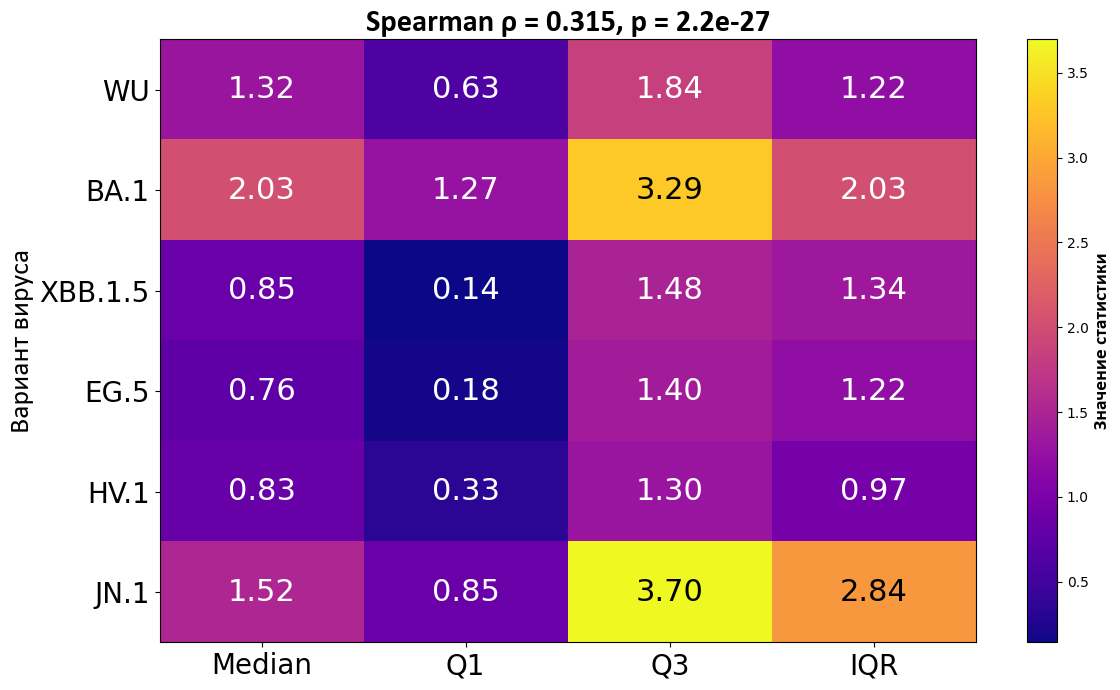

In [74]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_heatmap(stats_df, corr,
                 variant_order=None,
                 cmap: str = "viridis",
                 title_font: dict = None,
                 xlabel_font: dict = None,
                 ylabel_font: dict = None,
                 xtick_fontsize: int = 10,
                 ytick_fontsize: int = 10,
                 xtick_rotation: int = 0,
                 annot_fontsize: int = 10,
                 cbar_label_font: dict = None,
                 figsize: tuple = (10, 6)):
    """
    Строит тепловую карту статистик по вариантам с умным выбором цвета аннотаций в ячейках
    (тёмный текст на светлом фоне и белый на тёмном), с возможностью задать порядок вариантов.
    """
    # Переиндексация, если задан порядок
    if variant_order is not None:
        stats_df = stats_df.reindex(variant_order)

    data = stats_df.values
    fig, ax = plt.subplots(figsize=figsize)

    # Настраиваем нормализацию и карту цветов
    norm = mpl.colors.Normalize(vmin=data.min(), vmax=data.max())
    cmap_obj = mpl.cm.get_cmap(cmap)
    im = ax.imshow(data, aspect='auto', cmap=cmap_obj, norm=norm)

    # Колорбар
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Значение статистики')
    if cbar_label_font:
        label = cbar.ax.yaxis.label
        if 'fontsize' in cbar_label_font:
            label.set_fontsize(cbar_label_font['fontsize'])
        if 'fontfamily' in cbar_label_font:
            label.set_family(cbar_label_font['fontfamily'])
        if 'fontweight' in cbar_label_font:
            label.set_weight(cbar_label_font['fontweight'])

    # Подписи осей
    ax.set_xticks(range(len(stats_df.columns)))
    ax.set_xticklabels(stats_df.columns,
                       rotation=xtick_rotation,
                       ha='center',
                       fontsize=xtick_fontsize)
    ax.set_yticks(range(len(stats_df.index)))
    ax.set_yticklabels(stats_df.index, fontsize=ytick_fontsize)

    # Аннотации с умным цветом
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            rgba = cmap_obj(norm(val))
            # Вычисляем яркость: 0.299R + 0.587G + 0.114B
            lum = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
            text_color = 'white' if lum < 0.5 else 'black'
            ax.text(j, i, f"{val:.2f}",
                    ha='center', va='center',
                    fontsize=annot_fontsize, color=text_color)

    # Подписи и заголовок
    # ax.set_xlabel("Статистика", **(xlabel_font or {}))
    ax.set_ylabel("Вариант вируса", **(ylabel_font or {}))
    title_text = (
        f"Spearman ρ = {corr['corr_coef']:.3f}, p = {corr['p_value']:.1e}"
    )
    ax.set_title(title_text, **(title_font or {}))

    plt.tight_layout()
    plt.show()


# Пример вызова:
plot_heatmap(
    stats_df,
    corr,
    variant_order=['WU', 'BA.1', 'XBB.1.5', 'EG.5', 'HV.1', 'JN.1'],
    cmap="plasma",
    title_font={'fontsize':22, 'fontfamily':'Calibri', 'fontweight':'bold'},
    xlabel_font={'fontsize':18, 'fontfamily':'Calibri'},
    ylabel_font={'fontsize':20, 'fontfamily':'Calibri'},
    xtick_fontsize=20,
    ytick_fontsize=20,
    xtick_rotation=0,
    annot_fontsize=22,
    cbar_label_font={'fontsize':14, 'fontfamily':'Calibri', 'fontweight':'bold'},
    figsize=(12, 7)
)

In [ ]:
min_diff = pd.read_csv("C:\\Users\\Professional\\Documents\\docking_11.05.2025\\results\\2025_05_11\\min_diff.csv")
min_diff = min_diff.drop(columns=["Unnamed: 0"])

,Unnamed: 0,index,antibody,variant,pdb_id,Kd,Kd_reference,fold_change,log10_fold_change,Kd_diff
0,0,WU_6lzg_B-vhh57-2025_05_11-cluster_1_model_2.pdb,vhh57,WU,6lzg,4.900000e-10,5.190000e-10,0.944,-0.024971,2.900000e-11
1,1,WU_6lzg_B-vhh7-2025_05_11-cluster_5_model_1.pdb,vhh7,WU,6lzg,2.800000e-10,1.370000e-10,2.044,0.310437,1.430000e-10
2,2,WU_6lzg_B-vhh58-2025_05_11-cluster_3_model_3.pdb,vhh58,WU,6lzg,9.000000e-11,9.310000e-11,0.967,-0.014707,3.100000e-12
3,3,WU_6vw1_E-vhh57-2025_05_11-cluster_5_model_2.pdb,vhh57,WU,6vw1,5.300000e-10,5.190000e-10,1.021,0.009109,1.100000e-11
4,4,WU_6vw1_E-vhh7-2025_05_11-cluster_1_model_1.pdb,vhh7,WU,6vw1,8.600000e-11,1.370000e-10,0.628,-0.202222,5.100000e-11
5,5,WU_6vw1_E-vhh58-2025_05_11-cluster_6_model_2.pdb,vhh58,WU,6vw1,1.100000e-10,9.310000e-11,1.182,0.072443,1.690000e-11
6,6,WU_6w41_C-vhh7-2025_05_11-cluster_1_model_1.pdb,vhh7,WU,6w41,4.100000e-11,1.370000e-10,0.299,-0.523937,9.600000e-11
7,7,WU_6w41_C-vhh57-2025_05_11-cluster_1_model_1.pdb,vhh57,WU,6w41,3.800000e-10,5.190000e-10,0.732,-0.135384,1.390000e-10
8,8,WU_6w41_C-vhh58-2025_05_11-cluster_5_model_4.pdb,vhh58,WU,6w41,8.300000e-11,9.310000e-11,0.892,-0.049872,1.010000e-11
9,9,WU_7l7e_K-vhh57-2025_05_11-cluster_5_model_4.pdb,vhh57,WU,7l7e,4.900000e-10,5.190000e-10,0.944,-0.024971,2.900000e-11


In [89]:
# 2. Переименование клонов VHH
rename_map = {
    'vhh7':  '9A7',
    'vhh57': '9A57',
    'vhh58': '9A58'
}
min_diff['antibody'] = min_diff['antibody'].replace(rename_map)

# 3. Для каждой пары (variant, antibody) находим индекс строки с минимальным Kd_diff
idx = min_diff.groupby(['variant', 'antibody'])['Kd_diff'].idxmin()

# 4. Отбираем соответствующие строки и оставляем нужные столбцы
summary_df = min_diff.loc[idx, ['variant', 'antibody', 'Kd', 'Kd_reference', 'Kd_diff']].copy()
summary_df = summary_df.rename(columns={'Kd_diff': 'min_Kd_diff'})

# 5. Накладываем желаемый порядок
variant_order  = ['WU', 'BA.1', 'XBB.1.5', 'EG.5', 'HV.1', 'JN.1']
antibody_order = ['9A7', '9A57', '9A58']

summary_df['variant']  = pd.Categorical(
    summary_df['variant'],
    categories=variant_order,
    ordered=True
)
summary_df['antibody'] = pd.Categorical(
    summary_df['antibody'],
    categories=antibody_order,
    ordered=True
)

# 6. Сортировка по variant и antibody
summary_df = summary_df.sort_values(['variant', 'antibody']).reset_index(drop=True)
summary_df = summary_df.rename(columns={
    "variant": "Variant",
    "antibody": "VHH",
})

summary_df.to_excel("C:\\Users\\Professional\\Documents\\Disser\\Части\\Диплом\\min_kd_diff.xlsx")
summary_df

,Variant,VHH,Kd,Kd_reference,min_Kd_diff
0,WU,9A7,8.600000e-11,1.370000e-10,5.100000e-11
1,WU,9A57,5.300000e-10,5.190000e-10,1.100000e-11
2,WU,9A58,9.000000e-11,9.310000e-11,3.100000e-12
3,BA.1,9A7,3.100000e-10,1.570000e-10,1.530000e-10
4,BA.1,9A57,2.300000e-10,2.800000e-10,5.000000e-11
5,BA.1,9A58,6.600000e-11,1.000000e-13,6.590000e-11
6,XBB.1.5,9A7,2.600000e-09,2.390000e-09,2.100000e-10
7,XBB.1.5,9A57,1.300000e-09,1.150000e-09,1.500000e-10
8,XBB.1.5,9A58,6.300000e-11,6.310000e-11,1.000000e-13
9,HV.1,9A7,3.100000e-10,2.380000e-10,7.200000e-11


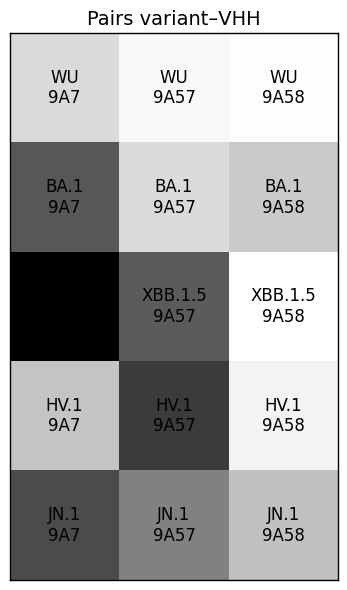

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# 1. Загрузка и подготовка данных (как раньше)
min_diff['antibody'] = min_diff['antibody'].replace({'vhh7':'9A7','vhh57':'9A57','vhh58':'9A58'})
idx = min_diff.groupby(['variant','antibody'])['Kd_diff'].idxmin()
summary_df = min_diff.loc[idx, ['variant','antibody','Kd_diff']].copy()
summary_df = summary_df.rename(columns={'Kd_diff':'min_Kd_diff'})

# жёсткий порядок
variant_order  = ['WU','BA.1','XBB.1.5','EG.5','HV.1','JN.1']
antibody_order = ['9A7','9A57','9A58']
summary_df['variant']  = pd.Categorical(summary_df['variant'],  categories=variant_order, ordered=True)
summary_df['antibody'] = pd.Categorical(summary_df['antibody'], categories=antibody_order, ordered=True)
summary_df = summary_df.sort_values(['variant','antibody']).reset_index(drop=True)

# Pivot: строки — варианты, столбцы — клоны
pivot_min = summary_df.pivot(index='variant', columns='antibody', values='min_Kd_diff')

# 2. Построение «табличной» карты с названиями внутри ячеек
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(pivot_min.values, cmap='Greys', aspect='equal')

# Убираем стандартные метки
ax.set_xticks([])
ax.set_yticks([])

# Аннотируем каждую ячейку названием сочетания
for i, variant in enumerate(pivot_min.index):
    for j, antibody in enumerate(pivot_min.columns):
        text = f"{variant}\n{antibody}"
        ax.text(j, i, text,
                ha='center', va='center',
                fontsize=12,
                color='black')

# Оформление: рамка и заголовок
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

ax.set_title("Pairs variant–VHH", fontsize=14)
plt.tight_layout()
plt.show()
